In [1]:
import xml.etree.cElementTree as ET
from collections import defaultdict

#First thing to do is to get the lisk of all k tags

osmfile = 'mapSmall'

list_of_k_types = set()
osm_file = open(osmfile, "r")
street_types = defaultdict(set)
for event, elem in ET.iterparse(osm_file, events=("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            list_of_k_types.add(tag.attrib['k'])
osm_file.close()

In [2]:
#list_of_k_types

In [3]:
#In the data cleaning process I will get rid of nodes that have a 'FIXME', 'FIXME-range' and 'FIXEM-range' 
#tags beccause I am not sure what they mean.

#Couple of problems I have noticed with the data is that some addresses have Northeast written in them while others
#have NE written in them. Same thing with other addresses. I am going to change all addresses to NE,SW,NW,NE and
#get rid of any variations of these terms.

#I have also noticed a problem with postal codes, some postal codes are written as t2m-0p2 while others are written
#as T2M-0P2 or T2M 0P2 or T2M0P2. I will standardize all postal codes as T2M 0P2

#Get a list of all bad street name:
import re

Acceptable_in_street_name = ['NW', 'NE', 'SW', 'SE']
PROBLEMATIC_NAMES = re.compile('[=\+/&<>;\t\r\n]')
list_of_bad_street_names = set()

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

osm_file = open(osmfile, "r")
for event, elem in ET.iterparse(osm_file, events=("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_street_name(tag):
                problematic_address = True
                m = PROBLEMATIC_NAMES.search(tag.attrib['v'])
                if not m:
                    for i in Acceptable_in_street_name:
                        if(tag.attrib['v'].find(i)>0):
                            problematic_address = False
                            break
                if(problematic_address):
                    #build up a list of all bad names and then comment this portion out and fix the name
                    list_of_bad_street_names.add(tag.attrib['v'])
                    #update_name(tag.attrib['v'], mapping_to_right_name)
osm_file.close()

print(list_of_bad_street_names)

{'West Creek Court', 'Grove Hill Road Southwest', '13 Avenue S.W.', 'Crossiron Boulevard', 'Macleod Trail', 'West Campus Place', '19 Street S.W.', 'Macleod Trail South', 'hidden creek rise nw', 'Crossiron Common', '523', '120 Avenue', 'Macleod Trail Southeast', '517', 'Acadia Drive', 'Maplemont Road', 'Elbow Drive', 'Lake Twintree Bay', 'Sage Valley Court Northwest', 'Wagon Wheel Way', 'Bonaventure Drive', 'Sunset Common', 'Bow Street', 'Strathcona Place Southwest', 'Wellington Cove', '16 Avenue NE;Trans-Canada Highway', 'Edgefield Place', 'WOODPARK BLVD S.W', 'Centre Street S', 'Coronado Place Northeast', 'MacLaurin Drive', 'Symons Valley Road N.W.', '4632 1st se', 'Center Street S', 'River Ave', 'Hawks Court Northwest', 'Oakfield Drive Southwest', '9 Avenue Southeast', '32 Avenue Northeast', 'Varsity Estates Road Northwest', 'Bracewood Cres', '72 Avenue Southeast', 'Montgomery View', '2452 Battleford Avenue S.W.', 'Macleod Trail S', '18A Street', '9th st', 'Indus Court', '30 Avenue S

In [4]:
mapping_to_right_name={'Northeast': 'NE','N.E.': 'NE', 'n.e.\n': 'NE', 'Northeast': 'NE', 
                       'nw': 'NW', 'Northwest': 'NW', 'N.W':'NW', 'Northwest': 'NW', 'N.W.': 'NW',
                      'Southwest': 'SW', 'S.W.': 'SW', 'South-west': 'SW',  
                      'Southeast': 'SE', 'S.E': 'SE',  'South-east': 'SE', 'se': 'SE'}

#There is only once that a space in is used to specify South East
Wrong_names_with_spaces={'South East': 'SE'}

#This function will correct the name and return it.
def update_name(name, mapping, map_names_with_spaces):
    name = name.split(" ")

    for i in range(len(name)):
        if name[i] in mapping:
            name[i] = mapping[name[i]]
        
    name = " ".join(name)
    
    for key in map_names_with_spaces:
        if key in name:
            name = name.replace(key, Wrong_names_with_spaces[key])

    return name

In [5]:
#This function will correct the postal code and return it.
def update_postal_code(postal_code):
    LOWER_COLON = re.compile(r'^[a-z]|_-+:')
    if(len(postal_code) == 6):
        postal_code = [postal_code[:3],postal_code[3:] ]
    else:
        postal_code = postal_code.split("-")
    
    postal_code = " ".join(postal_code)
    
    postal_code = postal_code.upper()

    return postal_code

In [6]:
#Now I will make the csv files

import csv

NODE_KEY = ['id', 'lat', 'lon', 'version', 'timestamp', 'uid']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
PROBLEM_FIX = ['FIXME', 'FIXME-range', 'FIXEM-rnage']

def shape_elements(elem):
    #elem.attrib is a dictionary
    if elem.tag == 'node':
        node_attrib = elem.attrib
        for key in node_attrib.copy():
            if key not in NODE_KEY:
                del node_attrib[key]
        with open(NODES_PATH, 'a') as f:
            w = csv.DictWriter(f, NODE_KEY)
            w.writerow(node_attrib)
        #Check if a node has tags
        for tag in elem.iter('tag'):
            empty_dict = {}
            if (not PROBLEMCHARS.search(tag.attrib['k']) and tag.attrib['k'] not in PROBLEM_FIX):
                if(tag.attrib['k'] == 'addr:street'):
                    tag.attrib['v'] = update_name(tag.attrib['v'], mapping_to_right_name, Wrong_names_with_spaces)
                if(tag.attrib['k'] == 'addr:postcode'):
                    tag.attrib['v'] = update_postal_code(tag.attrib['v'])
                if ':' in tag.attrib['k']:
                    colon_pos = tag.attrib['k'].find(':')
                    empty_dict['type'] = tag.attrib['k'][:colon_pos]
                    empty_dict['key'] = tag.attrib['k'][colon_pos+1:]
                else:
                    empty_dict['type'] = 'regular'
                    empty_dict['key'] = tag.attrib['k']
                empty_dict['id'] = node_attrib['id']
                empty_dict['value'] = tag.attrib['v']
            with open(NODE_TAGS_PATH, 'a') as f:
                w = csv.DictWriter(f, NODE_TAGS_FIELDS)
                w.writerow(empty_dict)
    
    elif elem.tag == 'way':
        way_attribs = elem.attrib
        for key in way_attribs.copy():
            if key not in WAY_FIELDS:
                del way_attribs[key]
        with open(WAYS_PATH, 'a') as f:
            w = csv.DictWriter(f, WAY_FIELDS)
            w.writerow(way_attribs)
        for tag in elem.iter('tag'):
            empty_dict = {}
            if not PROBLEMCHARS.search(tag.attrib['k']):
                if ':' in tag.attrib['k']:
                    colon_pos = tag.attrib['k'].find(':')
                    empty_dict['type'] = tag.attrib['k'][:colon_pos]
                    empty_dict['key'] = tag.attrib['k'][colon_pos+1:]
                else:
                    empty_dict['type'] = 'regular'
                    empty_dict['key'] = tag.attrib['k']
                empty_dict['id'] = way_attribs['id']
                empty_dict['value'] = tag.attrib['v']
            with open(WAY_NODES_PATH, 'a') as f:
                w = csv.DictWriter(f, WAY_TAGS_FIELDS)
                w.writerow(empty_dict)
        #This variable is to keep track of the node position
        zig = -1
        for nodes in elem.iter('nd'):
            empty_dict = {}
            zig+=1
            empty_dict['id'] = way_attribs['id']
            empty_dict['node_id'] = nodes.attrib['ref']
            empty_dict['position'] = zig
            with open(WAY_TAGS_PATH, 'a') as f:
                w = csv.DictWriter(f, WAY_NODES_FIELDS)
                w.writerow(empty_dict)

In [1]:
def audit(osmfile):
    #These statements create a new file or overwrite one if it already exists and write the header line.
    with open(NODES_PATH, 'w') as f:
        w = csv.DictWriter(f, NODE_KEY)
        w.writeheader()
    #If the node has tag
    with open(NODE_TAGS_PATH, 'w') as f:
        w = csv.DictWriter(f, NODE_TAGS_FIELDS)
        w.writeheader()
    #For Ways
    with open(WAYS_PATH, 'w') as f:
        w = csv.DictWriter(f, WAY_FIELDS)
        w.writeheader()
    #For ways tags
    with open(WAY_NODES_PATH, 'w') as f:
        w = csv.DictWriter(f, WAY_TAGS_FIELDS)
        w.writeheader()
    #For ways tags
    with open(WAY_TAGS_PATH, 'w') as f:
        w = csv.DictWriter(f, WAY_NODES_FIELDS)
        w.writeheader()
        
    osm_file = open(osmfile, "r")
    
    for event,elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == 'node' or elem.tag == 'way':
            shape_elements(elem)
    
    osm_file.close()

In [8]:
audit(osmfile)

In [9]:
def array_of_values(file_name, associated_dict):
    to_db = []
    with open(file_name,'r') as f: # `with` statement available in 2.5+
        # csv.DictReader uses first line in file for column headings by default
        dr = csv.DictReader(f) # comma is default delimiter
        for row in dr:
            temp=[]
            for key in associated_dict:
                temp.append(row[key])
            to_db.append(temp)
    return to_db

In [12]:
import sqlite3

conn = sqlite3.connect('sqlite3')
cur = conn.cursor()

cur.execute('''DROP TABLE IF EXISTS nodes''')
cur.execute('''DROP TABLE IF EXISTS nodes_tags''')
cur.execute('''DROP TABLE IF EXISTS ways''')
cur.execute('''DROP TABLE IF EXISTS ways_nodes_path''')
cur.execute('''DROP TABLE IF EXISTS ways_tags_path''')

#create nodes table
cur.execute('''CREATE TABLE IF NOT EXISTS 'nodes'( id INT NOT NULL, 
lat INT NOT NULL, lon INT NOT NULL, 
version CHAR NOT NULL, timestamp CHAR NOT NULL, 
uid CHAR NOT NULL, PRIMARY KEY (id) );''')

data_for_sql = array_of_values(NODES_PATH, NODE_KEY)

cur.executemany("INSERT INTO nodes (id, lat, lon, version, timestamp, uid) VALUES (?, ?, ?, ?, ?, ?);", data_for_sql)
conn.commit()

#create nodes_tags table
cur.execute('''CREATE TABLE 'nodes_tags' ( id INT NOT NULL, key CHAR NOT NULL, value CHAR NOT NULL, 
type CHAR NOT NULL, FOREIGN KEY (id) REFERENCES nodes(id) );''')

data_for_sql = array_of_values(NODE_TAGS_PATH, NODE_TAGS_FIELDS)

cur.executemany("INSERT INTO nodes_tags (id, key, value, type) VALUES (?, ?, ?, ?);", data_for_sql)
conn.commit()

#create ways table
cur.execute('''CREATE TABLE 'ways' ( id INT NOT NULL, user CHAR NOT NULL, 
uid INT NOT NULL, version INT NOT NULL, changeset INT NOT NULL, timestamp CHAR NOT NULL, 
PRIMARY KEY (id) );''');

data_for_sql = array_of_values(WAYS_PATH, WAY_FIELDS)

cur.executemany("INSERT INTO ways (id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);", 
                data_for_sql)
conn.commit()

#create ways_nodes_path table
cur.execute('''CREATE TABLE 'ways_nodes_path' ( id INT NOT NULL, key CHAR NOT NULL, value CHAR NOT NULL, 
type CHAR NOT NULL, FOREIGN KEY (id) REFERENCES ways(id) );''');

data_for_sql = array_of_values(WAY_NODES_PATH, WAY_TAGS_FIELDS)

cur.executemany("INSERT INTO ways_nodes_path (id, key, value, type) VALUES (?, ?, ?, ?);", 
                data_for_sql)
conn.commit()

#create ways_tags_path table
cur.execute('''CREATE TABLE 'ways_tags_path' ( id INT NOT NULL, node_id INT NOT NULL, position INT NOT NULL, 
FOREIGN KEY (id) REFERENCES ways(id), FOREIGN KEY (node_id) REFERENCES nodes(id) );''');

data_for_sql = array_of_values(WAY_TAGS_PATH, WAY_NODES_FIELDS)

cur.executemany("INSERT INTO ways_tags_path (id, node_id, position) VALUES (?, ?, ?);", 
                data_for_sql)
conn.commit()

import pandas as pd
#Query to find the number of unique nodes by id
Number_of_nodes = pd.read_sql_query('''SELECT COUNT(id) FROM nodes''', conn)

#Query to find the number of unique ways by id
Number_of_ways = pd.read_sql_query('''SELECT COUNT(id) FROM ways''', conn)


#Query to find the number of Tim Hortons
Total_number_of_tim_hortons = pd.read_sql_query('''SELECT COUNT(*) FROM (SELECT id, key, value FROM nodes_tags 
WHERE value = 'Tim Hortons' GROUP by id);''', conn);

#Get the lon and lat of all the tim hortons for graphing
Tim_Horton_locations = pd.read_sql_query('''SELECT lon, lat 
FROM nodes
JOIN nodes_tags 
ON nodes.id = nodes_tags.id
WHERE value = 'Tim Hortons'
GROUP BY nodes.id''', conn)

#Get the number of starbuck
Total_number_of_startbucks = pd.read_sql_query('''SELECT COUNT(*) FROM (SELECT id, key, value FROM nodes_tags 
WHERE value = 'Starbucks' GROUP by id);''', conn);

#Get the lon and lat of all the tim hortons for graphing
Stabucks_locations = pd.read_sql_query('''SELECT lon, lat 
FROM nodes
JOIN nodes_tags 
ON nodes.id = nodes_tags.id
WHERE value = 'Starbucks'
GROUP BY nodes.id''', conn)

#Get the total number of contributors
Total_contributors = pd.read_sql_query('''SELECT COUNT(DISTINCT uid) FROM ways;''', conn)

#Find out how many contributions each contributor made
Contributions_by_contributor = pd.read_sql_query('''SELECT uid, COUNT(uid) FROM ways GROUP BY uid 
ORDER BY COUNT(uid) DESC;''', conn)


conn.close()
print('Number_of_nodes = ', Number_of_nodes)
print('Number_of_ways = ', Number_of_ways)

Number_of_nodes =     COUNT(id)
0     700200
Number_of_ways =     COUNT(id)
0      85816


In [13]:
#Now we make a plot of the distributions of Tim Hortons and Starbucks in Calgary
import folium


Calg_COORDINATES = (51, -114)

map = folium.Map(location=Calg_COORDINATES, zoom_start=10)

#add a marker for every timmies",
for data in Tim_Horton_locations.iterrows():
    map.circle_marker(location = [data[1]['lat'],data[1]['lon']], radius = 100, line_color = 'green', 
                      fill_color='green')
    
#add a marker for every starbucks",
for data in Stabucks_locations.iterrows():
    map.circle_marker(location = [data[1]['lat'],data[1]['lon']], radius = 100, line_color = 'red', 
                      fill_color='red')

path = 'my_map.html'
map.create_map(path)

map

/home/usman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
/home/usman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
/home/usman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: Map.create_map is deprecated. Use Map.save instead


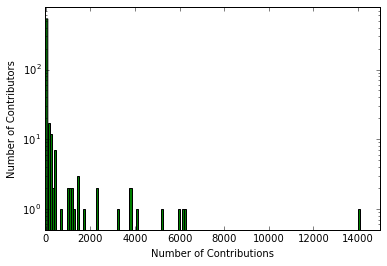

In [14]:
#Now make a bar graph to show the number of contributions by contributors
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

data = []

for row in Contributions_by_contributor.iterrows():
    data.append(row[1]['COUNT(uid)']);

plt.xlabel('Number of Contributions');
plt.ylabel('Number of Contributors');
plt.yscale('log', nonposy='clip')
ax.set_ylim(0.5, 800)
ax.set_xlim(-10,15000)
plt.hist(data, bins=150, facecolor='g');

In [16]:
print('Total_number_of_tim_hortons = ',  Total_number_of_tim_hortons)
print('Total_number_of_Starbucks = ',  Total_number_of_startbucks)
print('Total_contributors = ', Total_contributors)



Total_number_of_tim_hortons =     COUNT(*)
0        51
Total_number_of_Starbucks =     COUNT(*)
0        27
Total_contributors =     COUNT(DISTINCT uid)
0                  594
